In [1]:
type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

### Prepare data

In [2]:
############
#Read in the demand file
file = open("../data_original/SiouxFalls_trips_simp.txt")
demands = Dict{(Int64,Int64), Float64}()
s = 0
for line in eachline(file)
    if contains(line, "Origin")
        s = int(split(line)[2])
    else
        pairs = split(line, ";")
        for pair in pairs
            if !contains(pair, "\n")
                pair_vals = split(pair, ":")
                t, demand = int(pair_vals[1]), float(pair_vals[2])
                demands[(s,t)] = demand 
            end
        end
    end
end                
close(file)

############
#read in the arc files
arcs = Dict{(Int, Int), Arc}()
file = open("../data_original/SiouxFalls_net_simp.txt")
inHeader=true
for line in eachline(file)
    if inHeader
        inHeader = !contains(line, "Init node")
        continue
    end
    vals = split(line, )
    arcs[(int(vals[1]), int(vals[2]))] = Arc(int(vals[1]), int(vals[2]), float(vals[3]), float(vals[5]))
end
close(file)

###########
#read in the initial flows
file = open("../data_original/flows_converge_simp.txt")
ix = 0; 
for line in eachline(file)
    ix +=1
    if ix ==1
        continue
    end
    vals = split(line)
    arcs[(int(vals[1]), int(vals[2]))].flow = float(vals[3])
end
close(file)

##########
# Set up demand data and flow data
##########
using Graphs

flow_data = Array(Float64, length(arcs))
flows = Dict{(Int64,Int64), Float64}()
demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs)
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end

for odpair in keys(demands)
    if ! haskey(demand_data, odpair)
        demand_data[odpair] = [demands[odpair], ]
    else
        push!(demand_data[odpair], demands[odpair])
    end
end

flow_data = [a.flow::Float64 for a in vArcs]

for a in vArcs
    flows[(a.initNode, a.termNode)] = a.flow
end

## Solve an inverse tarffic problem over polynomials of degree at most d

## Optionally use a regularizer from the poly kernel

In [3]:
using JuMP
using Gurobi
# using Roots

polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

function facto(m::Int64)
    factori = 1
    for j = 1:m
        factori = factori * j
    end
    return factori
end

function comb(n::Int64, m::Int64)
    combi = facto(n) / (facto(m) * facto(n-m))
    return int(combi)
end

function setUpFitting(deg::Int64, c::Float64)
    
    normCoeffs = Array(Float64, deg+1)
    for i=1:deg + 1
        normCoeffs[i] = comb(deg, i-1) * c^(deg-i+1)
    end

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])

	return m, coeffs, normCoeffs

end

function addResid(m, coeffs, ys, demands, arcs, scaling)
    @defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )

	return resid
end

function addIncreasingCnsts(m, coeffs, arcs)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]))
	end
end

function normalize(m, coeffs)
    @addConstraint(m, coeffs[1] == 1)
end

function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end


##########
#Fitting Funcs
##########

function train(lam::Float64, deg::Int, c::Float64, demands, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, normCoeffs = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs)  #uses the original obs flows

    normalize(m, coeffs)

    resids = Variable[]
    
    #copy the flow data over to the arcs
    for (ix, a) in enumerate(vArcs)
        a.flow = flow_data[ix]
    end

    #Dual Feasibility
    ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)

    #add the residual for this data point
    push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))


    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} 
                            + lam * sum{coeffs[i] * coeffs[i] / normCoeffs[i], i=1:deg + 1})
    solve(m)
    
    return [getValue(coeffs[i]) for i =1:length(coeffs)], getValue(ys), getValue(resids)
end

#nodeLink["0-75"]

train (generic function with 1 method)

In [4]:
#demands[(1, 1)]

#include("trafficCval.jl")

coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

deg = 6
c = 3.41
lam = 1.

fcoeffs, ys, resids = train(lam, deg, c, demands, flow_data, arcs)
coeffs_dict[(deg, c, lam)] = fcoeffs

7-element Array{Float64,1}:
  1.0       
  0.00509747
 -0.0436057 
  0.111642  
  0.069514  
  0.0162174 
  0.00141756

### Visualize the estimated cost function

INFO: Loading help data...


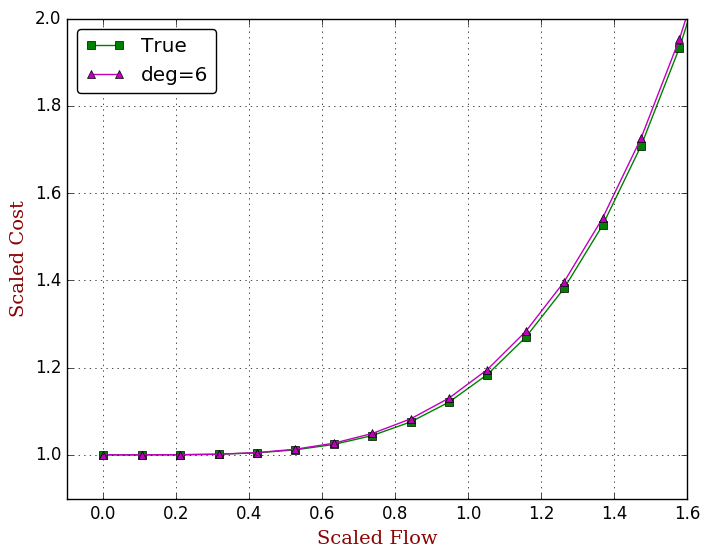

In [5]:
using PyPlot

true_coeffs = [1, 0, 0, 0, .15]

fcoeffs = coeffs_dict[(6, 3.41, 1.)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(fcoeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("fitting_Sioux_simp.pdf")